In [1]:
# the version of Yao is 0.4.1 in this notebook
using Yao, Yao.ConstGate
using Plots, LaTeXStrings

# Variational Quantum Eigensolver
* a quantum hamiltonain is a matrix (or MPO)
* a quantum state is a vector (or MPS)

## (Transverse field) ising Model

In [15]:
"""get the hamiltonian of a TFI model"""
function tfi_hamiltonian(nsite::Int, h::Real)
    sum([repeat(nsite, Z, (i,i+1)) for i=1:nsite-1]...) +
    h*chain([put(nsite, i=>X) for i=1:nsite])
end

tfi_hamiltonian

In [24]:
hami = tfi_hamiltonian(4, 0.4)

nqubits: 4
sum
├─ sum
│  ├─ repeat on (1, 2)
│  │  └─ Z gate
│  ├─ repeat on (2, 3)
│  │  └─ Z gate
│  └─ repeat on (3, 4)
│     └─ Z gate
└─ [scale: 0.4] chain
      ├─ put on (1)
      │  └─ X gate
      ├─ put on (2)
      │  └─ X gate
      ├─ put on (3)
      │  └─ X gate
      └─ put on (4)
         └─ X gate


In [25]:
ishermitian(hami)

true

In [26]:
Hmat = mat(hami)

16×16 SparseArrays.SparseMatrixCSC{Complex{Float64},Int64} with 32 stored entries:
  [1 ,  1]  =  3.0+0.0im
  [16,  1]  =  0.4+0.0im
  [2 ,  2]  =  1.0+0.0im
  [15,  2]  =  0.4+0.0im
  [3 ,  3]  =  -1.0+0.0im
  [14,  3]  =  0.4+0.0im
  [4 ,  4]  =  1.0+0.0im
  [13,  4]  =  0.4+0.0im
  [5 ,  5]  =  -1.0+0.0im
  [12,  5]  =  0.4+0.0im
  [6 ,  6]  =  -3.0+0.0im
  [11,  6]  =  0.4+0.0im
  ⋮
  [6 , 11]  =  0.4+0.0im
  [11, 11]  =  -3.0+0.0im
  [5 , 12]  =  0.4+0.0im
  [12, 12]  =  -1.0+0.0im
  [4 , 13]  =  0.4+0.0im
  [13, 13]  =  1.0+0.0im
  [3 , 14]  =  0.4+0.0im
  [14, 14]  =  -1.0+0.0im
  [2 , 15]  =  0.4+0.0im
  [15, 15]  =  1.0+0.0im
  [1 , 16]  =  0.4+0.0im
  [16, 16]  =  3.0+0.0im

## Differential programming to obtain the ground state

In [27]:
using Zygote: gradient
using Zygote

In [28]:
using LinearAlgebra

E, V = eigen(Hmat |> Matrix)
@show E[1]

E[1] = -3.3999999999999995


-3.3999999999999995

# The vector representation solution

In [29]:
f(x) = real(x'*Hmat*x/(x'*x))[]

x = randn(ComplexF64, size(Hmat, 2))
α = 0.5

for i = 1:100
    g = f'(x)
    x -= α .* g
    println("Energy is $(f(x))")
end

Energy is -0.8345385858647039
Energy is -1.1212028139050838
Energy is -1.3934116893855493
Energy is -1.646898874000442
Energy is -1.8788185701335633
Energy is -2.0877369699924007
Energy is -2.2734430040734974
Energy is -2.4366679732003482
Energy is -2.5787912235288606
Energy is -2.7015803016540016
Energy is -2.8069861432701178
Energy is -2.8969949019878456
Energy is -2.97352854801918
Energy is -3.0383834854759555
Energy is -3.093196994047006
Energy is -3.139433123816462
Energy is -3.1783816406711427
Energy is -3.211165307522338
Energy is -3.2387521101138073
Energy is -3.2619700384301646
Energy is -3.2815227839611607
Energy is -3.29800526881832
Energy is -3.31191833012804
Energy is -3.323682176151865
Energy is -3.3336484355290597
Energy is -3.34211075900089
Energy is -3.3493140210709402
Energy is -3.355462221030453
Energy is -3.3607252094385776
Energy is -3.3652443757529937
Energy is -3.3691374314767977
Energy is -3.372502415314435
Energy is -3.375421035459379
Energy is -3.3779614513036

In [30]:
using Random
using QuAlgorithmZoo: random_diff_circuit
using Plots
Random.seed!(2);

┌ Info: Recompiling stale cache file /home/leo/.julia/compiled/v1.1/QuAlgorithmZoo/11voS.ji for QuAlgorithmZoo [65c24e16-9b0a-11e8-1353-efc5bc5f6586]
└ @ Base loading.jl:1184


In [31]:
function train!(circuit, hami; maxiter=200, α=0.3)
    nbit = nqubits(circuit)
    rots = collect_blocks(RotationGate, circuit)
    loss_history = Float64[]
    for i in 0:maxiter
        for (j,r) in enumerate(rots)
            dispatch!(+, r, π/2)
            E₊ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(-, r, π)
            E₋ = expect(hami, zero_state(nbit) |> circuit) |> real
            dispatch!(+, r, π/2)
            g = 0.5(E₊ - E₋)
            dispatch!(-, r, α*g)
        end
        push!(loss_history, expect(hami, zero_state(nbit) |> circuit) |> real)
        
        if i%10 == 0
            println("Iter $i, E = $(loss_history[end])")
        end
    end
    loss_history, circuit
end

train! (generic function with 1 method)

In [32]:
circuit = random_diff_circuit(4, 2, [1=>2, 2=>3, 3=>4, 4=>1])

nqubits: 4
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.0)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, 0.0)
│     └─ put on (4)
│        └─ rot(Z gate, 0.0)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(Z gate, 0.0)
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 0.0)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, 0.0)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ ro

![_differentiable.png](images/_differential.png)

In [33]:
expect(hami, rand_state(4))

0.3524705262853929 + 0.0im

In [34]:
train!(dispatch!(circuit, :random), hami; maxiter=1000)

Iter 0, E = -0.08520422304283935
Iter 10, E = -3.2980527504629604
Iter 20, E = -3.393133904024836
Iter 30, E = -3.398691789251759
Iter 40, E = -3.399565898245145
Iter 50, E = -3.399823368854084
Iter 60, E = -3.399923999768127
Iter 70, E = -3.3999667560453726
Iter 80, E = -3.399985372188293
Iter 90, E = -3.399993547459433
Iter 100, E = -3.3999971503795
Iter 110, E = -3.399998740804442
Iter 120, E = -3.3999994434181
Iter 130, E = -3.3999997539431996
Iter 140, E = -3.3999998912118823
Iter 150, E = -3.3999999518993462
Iter 160, E = -3.3999999787316098
Iter 170, E = -3.3999999905956884
Iter 180, E = -3.3999999958416107
Iter 190, E = -3.399999998161232
Iter 200, E = -3.3999999991869245
Iter 210, E = -3.3999999996404684
Iter 220, E = -3.3999999998410213
Iter 230, E = -3.3999999999297024
Iter 240, E = -3.3999999999689168
Iter 250, E = -3.3999999999862554
Iter 260, E = -3.399999999993922
Iter 270, E = -3.3999999999973136
Iter 280, E = -3.399999999998812
Iter 290, E = -3.3999999999994746
Iter 30

([-0.0852042, -0.781717, -1.34603, -1.78548, -2.1709, -2.53917, -2.84915, -3.05706, -3.1797, -3.25252  …  -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4, -3.4], nqubits: 4
chain
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(X gate, 1.5707963267948966)
│  │  └─ put on (1)
│  │     └─ rot(Z gate, 1.5707963267948966)
│  ├─ chain
│  │  ├─ put on (2)
│  │  │  └─ rot(X gate, 1.4161184340117048)
│  │  └─ put on (2)
│  │     └─ rot(Z gate, -0.2067629464761885)
│  ├─ chain
│  │  ├─ put on (3)
│  │  │  └─ rot(X gate, -1.1990408665951691e-15)
│  │  └─ put on (3)
│  │     └─ rot(Z gate, 0.5791106438434195)
│  └─ chain
│     ├─ put on (4)
│     │  └─ rot(X gate, 0.0)
│     └─ put on (4)
│        └─ rot(Z gate, 0.11448036365226955)
├─ chain
│  ├─ control(1)
│  │  └─ (2,) X gate
│  ├─ control(2)
│  │  └─ (3,) X gate
│  ├─ control(3)
│  │  └─ (4,) X gate
│  └─ control(4)
│     └─ (1,) X gate
├─ chain
│  ├─ chain
│  │  ├─ put on (1)
│  │  │  └─ rot(Z gate, 0.20676294647618879)
│  │  ├─

# Gradient Vanishing Problem

https://arxiv.org/abs/1803.11173

In [53]:
using Statistics

function rand_gradient(hami::AbstractBlock)
    N = nqubits(hami)
    V1j = rand_unitary(1<<N) |> matblock
    V2j = rand_unitary(1<<N) |> matblock

    Uj = put(N, 1=>Rx(0.0))
    c = chain(N, [V1j, Uj, V2j])
    
    η = rand()*2π
    dispatch!(Uj, η+π/2)
    y₊ = expect(hami, zero_state(N) |> c) |> real

    dispatch!(Uj, η-π/2)
    y₋ = expect(hami, zero_state(N) |> c) |> real
    (y₊ - y₋)/2
end

maxN = 9
grad_vars = [mean([abs(rand_gradient(put(N, 1=>Z))) for i=1:100]) for N=1:maxN]

9-element Array{Float64,1}:
 0.4059330395956129  
 0.25136200168409156 
 0.1970885973573447  
 0.12772870055240237 
 0.109690519544569   
 0.07760827186061026 
 0.05082867358284546 
 0.03170525147755411 
 0.021470617399368067

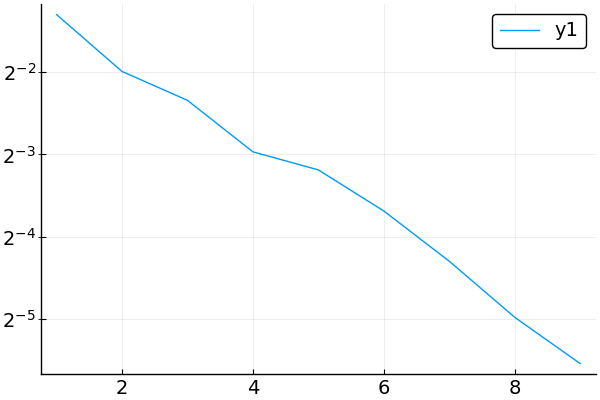

In [56]:
# see a exponential decreasing curve
ax = plot(1:maxN, grad_vars, yscale=:log2)